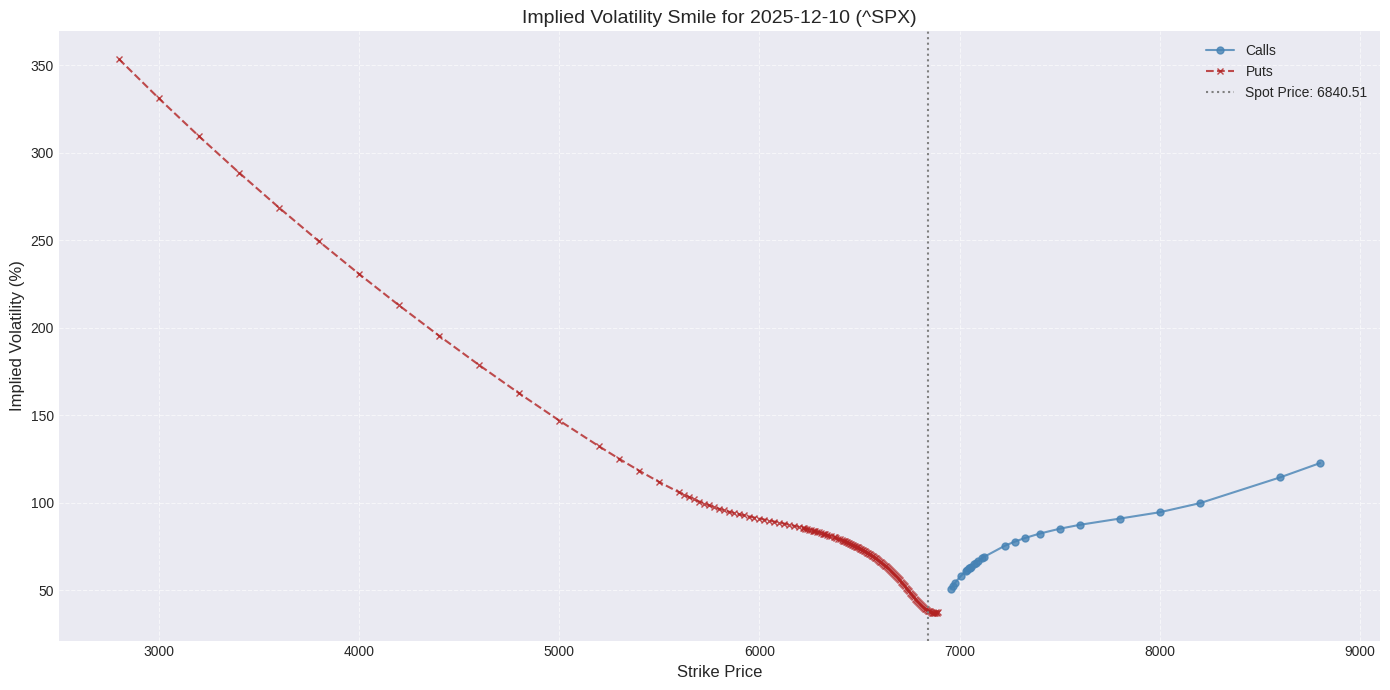

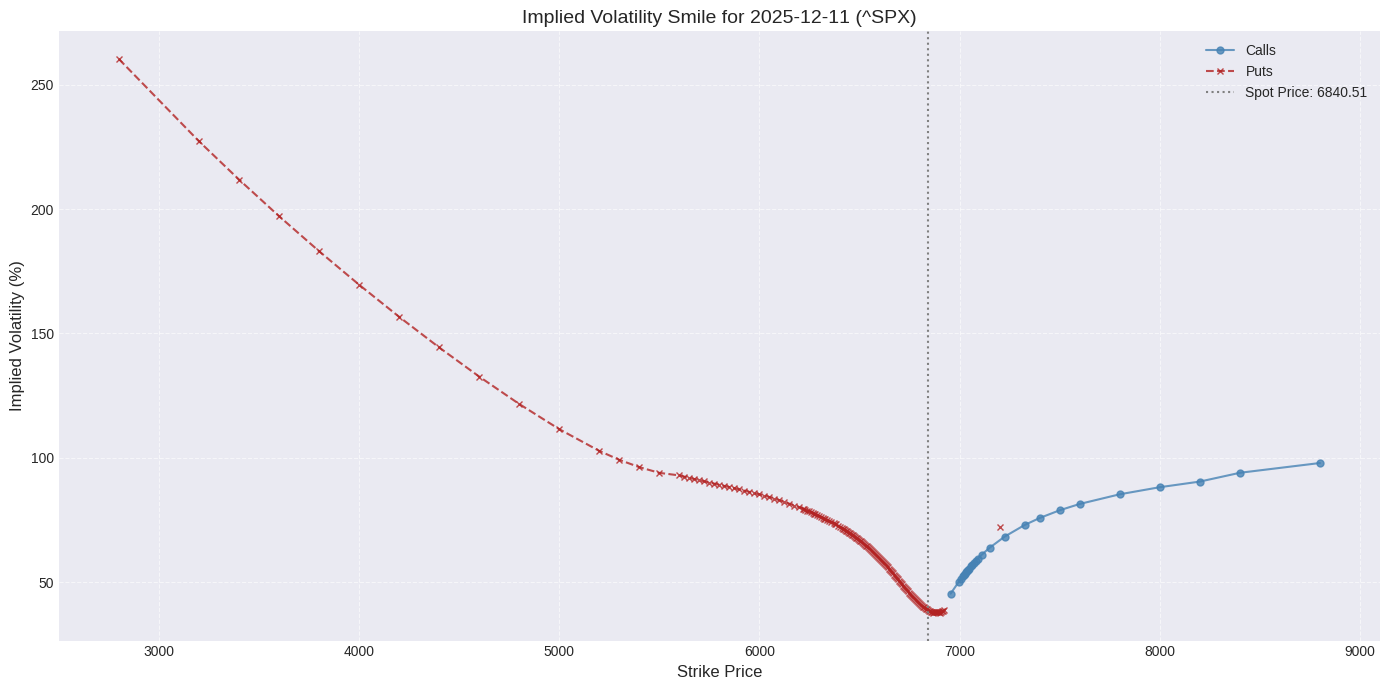

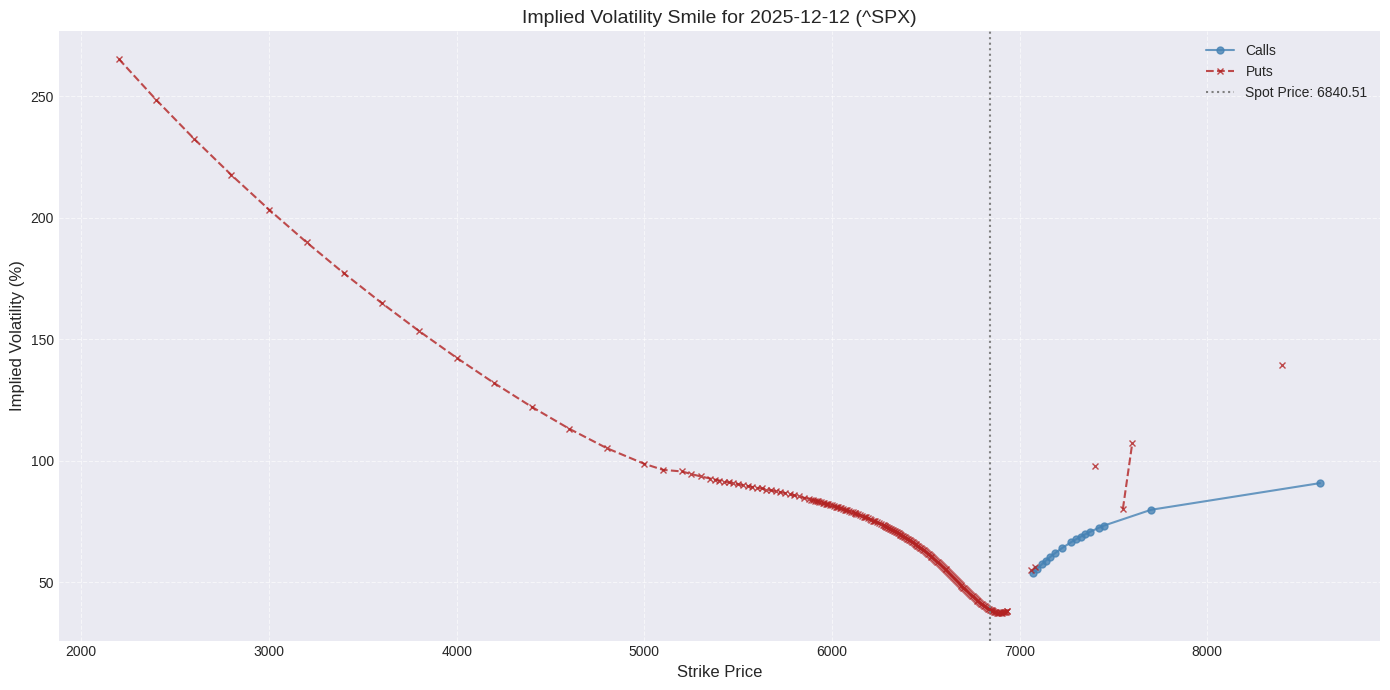

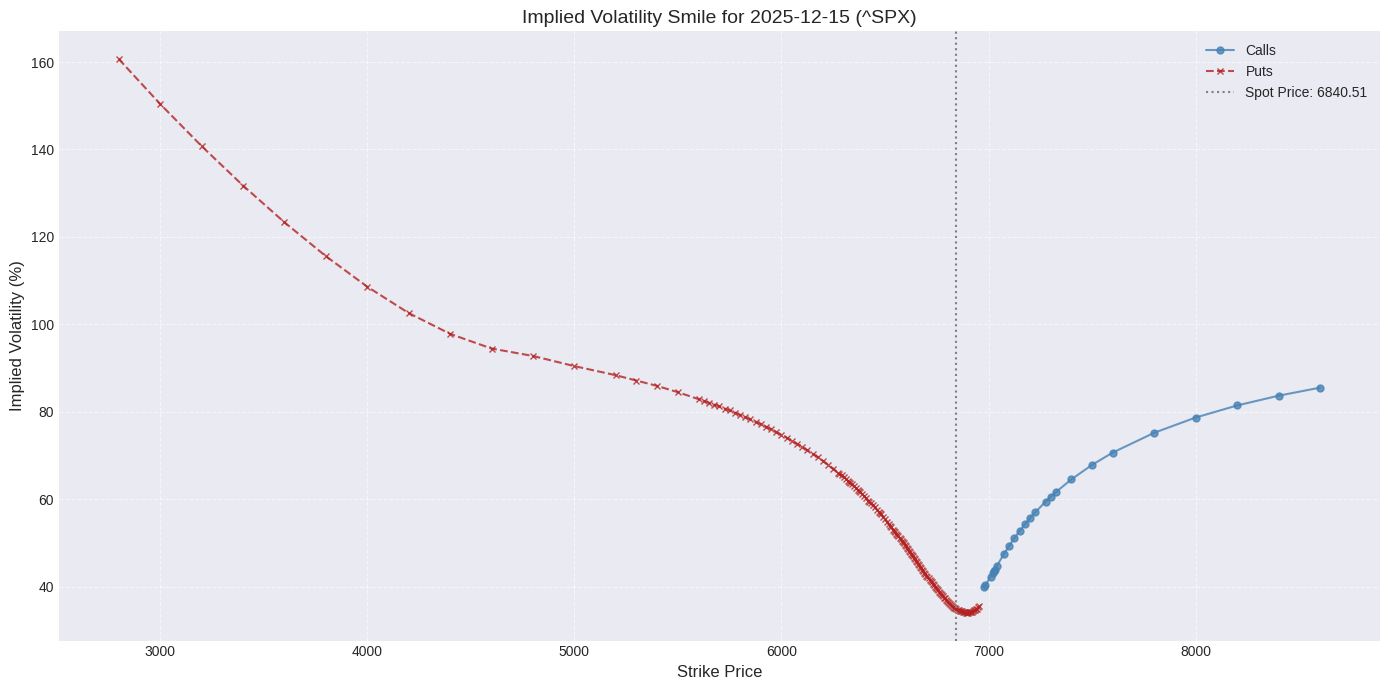

In [ ]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import brentq
import math

def black_price(S, K, sigma, T, is_call):
    if T <= 0:
        return max(S-K,0) if is_call else max(K-S,0)
    d1 = (np.log(S/K)+(sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*sigma*np.sqrt(T)
    if is_call:
        return S*norm.cdf(d1) - K*norm.cdf(d2)
    else:
        return K*norm.cdf(-d2) - S*norm.cdf(-d1)

def implied_vol(mkt, S, K, T, is_call):
    try:
        def f(sig):
            return black_price(S,K,sig,T,is_call) - mkt
        return brentq(f, 1e-6, 5, maxiter=500)
    except:
        return np.nan

symbol = '^SPX'

spx = yf.Ticker(symbol)

yesterday = datetime.date.today() - datetime.timedelta(days=1)

hist = spx.history(start=yesterday, end=yesterday + datetime.timedelta(days=1))
spot = float(hist["Close"].iloc[-1])

all_exps = spx.options
start_exp_request = datetime.date.today()

selected_exps = []
for exp_str in all_exps:
    current_exp_date = datetime.datetime.strptime(exp_str, "%Y-%m-%d").date()
    if current_exp_date >= start_exp_request:
        selected_exps.append(exp_str)
    if len(selected_exps) == 4:
        break
exps = selected_exps

results = {}

for exp in exps:
    chain = spx.option_chain(exp)
    calls = chain.calls.copy()
    puts = chain.puts.copy()

    T = (datetime.datetime.strptime(exp, "%Y-%m-%d").date() - yesterday).days / 365

    calls["mid"] = (calls["bid"] + calls["ask"]) / 2
    puts["mid"] = (puts["bid"] + puts["ask"]) / 2

    call_iv_list = []
    for _, row in calls.iterrows():
        K = row["strike"]
        m = row["mid"]
        if m > 0:
            iv = implied_vol(m, spot, K, T, True)
            call_iv_list.append((K, iv))
    calls_df = pd.DataFrame(call_iv_list, columns=["strike", "iv"])

    put_iv_list = []
    for _, row in puts.iterrows():
        K = row["strike"]
        m = row["mid"]
        if m > 0:
            iv = implied_vol(m, spot, K, T, False)
            put_iv_list.append((K, iv))
    puts_df = pd.DataFrame(put_iv_list, columns=["strike", "iv"])

    results[exp] = {'calls': calls_df, 'puts': puts_df}

plt.style.use('seaborn-v0_8-darkgrid') # Use a nicer plot style

for exp, data in results.items():
    plt.figure(figsize=(14,7)) # Slightly larger figure size

    # Identify common strikes to filter calls
    puts_strikes = set(data['puts']["strike"].dropna())
    calls_strikes = set(data['calls']["strike"].dropna())
    common_strikes = puts_strikes.intersection(calls_strikes)

    # Filter calls to exclude strikes where puts are plotted
    filtered_calls = data['calls'][~data['calls']["strike"].isin(common_strikes)].copy()

    if not filtered_calls.empty:
        plt.plot(filtered_calls["strike"], filtered_calls["iv"]*100,
                 marker="o", markersize=5, linestyle='-', label="Calls", color='steelblue', alpha=0.8)

    if not data['puts'].empty:
        plt.plot(data['puts']["strike"], data['puts']["iv"]*100,
                 marker="x", markersize=5, linestyle='--', label="Puts", color='firebrick', alpha=0.8)

    # Add a vertical line at the spot price
    plt.axvline(x=spot, color='gray', linestyle=':', linewidth=1.5, label=f'Spot Price: {spot:.2f}')

    plt.xlabel("Strike Price", fontsize=12)
    plt.ylabel("Implied Volatility (%)", fontsize=12)
    plt.title(f"Implied Volatility Smile for {exp} ({symbol})", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)
    plt.tight_layout() # Adjust layout to prevent labels from being cut off
    plt.show()